# ARIMA model for predict today's tesla stock price (yejin)

- reference 

: https://www.youtube.com/watch?v=rsva2qmhGyE (Predict Stock Price using ARIMA model (Python))

: https://www.youtube.com/watch?v=gqryqIlvEoM (How to Choose the p, d, q Terms to Build ARIMA Model)

- book 52p (pdf 77p) : identifying MA order by looking ACF. 
- book 59p : EACF for ARMA 
- book 68p : Differncing(ARIMA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from time import time
import datetime
import warnings

warnings.filterwarnings("ignore")

In [2]:
#import tesla data
ticker = 'TSLA'
data = yf.Ticker(ticker)
data

yfinance.Ticker object <TSLA>

In [3]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=730)
tomorrow = end_date + datetime.timedelta(days=1)
prices = data.history(start=start_date,end=end_date).Close
prices

Date
2023-01-09 00:00:00-05:00    119.769997
2023-01-10 00:00:00-05:00    118.849998
2023-01-11 00:00:00-05:00    123.220001
2023-01-12 00:00:00-05:00    123.559998
2023-01-13 00:00:00-05:00    122.400002
                                ...    
2024-12-27 00:00:00-05:00    431.660004
2024-12-30 00:00:00-05:00    417.410004
2024-12-31 00:00:00-05:00    403.839996
2025-01-02 00:00:00-05:00    379.279999
2025-01-03 00:00:00-05:00    410.440002
Name: Close, Length: 500, dtype: float64

In [4]:
print(end_date)
print(tomorrow)

2025-01-06
2025-01-07


In [5]:
prices.describe()

count    500.000000
mean     225.656720
std       58.893594
min      118.849998
25%      183.835003
50%      216.690002
75%      251.495003
max      479.859985
Name: Close, dtype: float64

In [6]:
#calculate returns
returns = prices.pct_change().dropna()
returns

Date
2023-01-10 00:00:00-05:00   -0.007681
2023-01-11 00:00:00-05:00    0.036769
2023-01-12 00:00:00-05:00    0.002759
2023-01-13 00:00:00-05:00   -0.009388
2023-01-17 00:00:00-05:00    0.074265
                               ...   
2024-12-27 00:00:00-05:00   -0.049479
2024-12-30 00:00:00-05:00   -0.033012
2024-12-31 00:00:00-05:00   -0.032510
2025-01-02 00:00:00-05:00   -0.060816
2025-01-03 00:00:00-05:00    0.082156
Name: Close, Length: 499, dtype: float64

Text(0, 0.5, 'Returns')

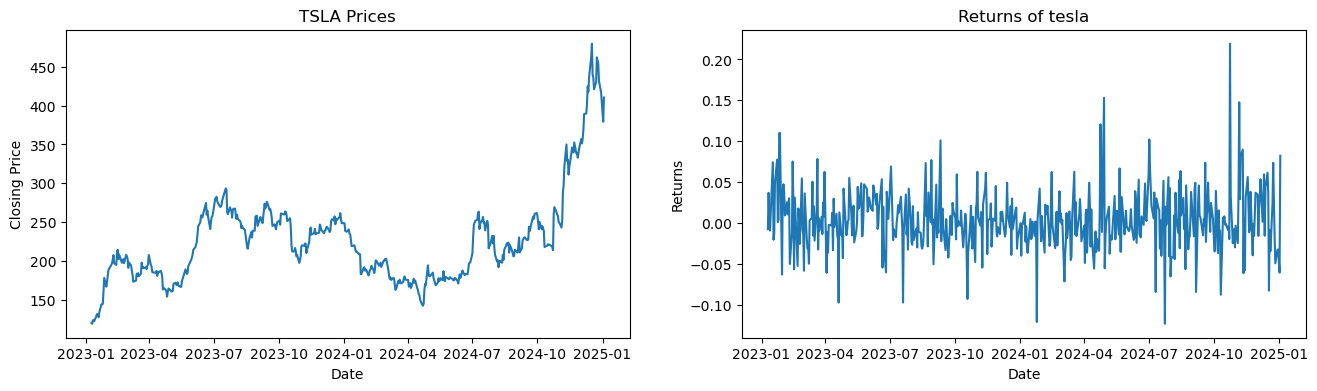

In [7]:
fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(prices)
ax1.set_title("TSLA Prices")
ax1.set_xlabel("Date")
ax1.set_ylabel("Closing Price")

ax2.plot(returns)
ax2.set_title("Returns of tesla")
ax2.set_xlabel("Date")
ax2.set_ylabel("Returns")

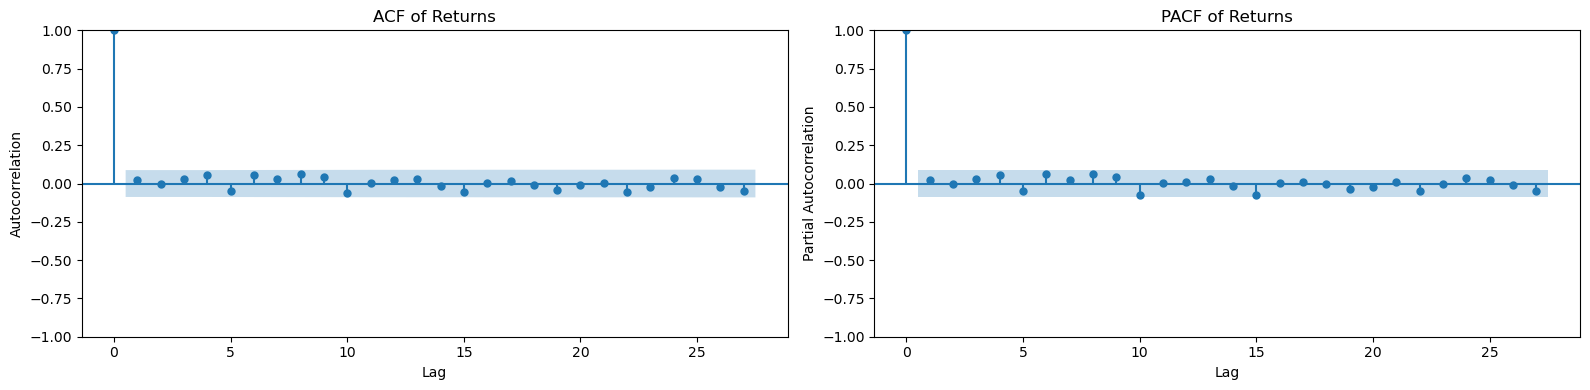

In [8]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# ACF Plot
plot_acf(returns, ax=ax1)
ax1.set_title("ACF of Returns")
ax1.set_xlabel("Lag")
ax1.set_ylabel("Autocorrelation")

# PACF Plot
plot_pacf(returns, ax=ax2, method='ywm')
ax2.set_title("PACF of Returns")
ax2.set_xlabel("Lag")
ax2.set_ylabel("Partial Autocorrelation")

plt.tight_layout()
plt.show()

# Stationary 

### ADF test (Augumented Dickey Fuller test) to check if the price series is stationary. 

Null hypothesis of the ADF test : time series is non-stationary.
So, if the p-value of the test is less than the significance level(0.05) then we can reject the null hypothesis and fer that time series is indeed stationary. 

In [9]:
#check if price series is stationary 
from statsmodels.tsa.stattools import adfuller

result = adfuller(prices.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -0.6810037784942401
p-value: 0.8516088225528069


### interpretation : p-value is clearly high, it means this time series is non stationary.
in our case, the p-value > 0.05 we'll need fo find the order of differencing.

# Autocorrelation function(ACF)

### find d order

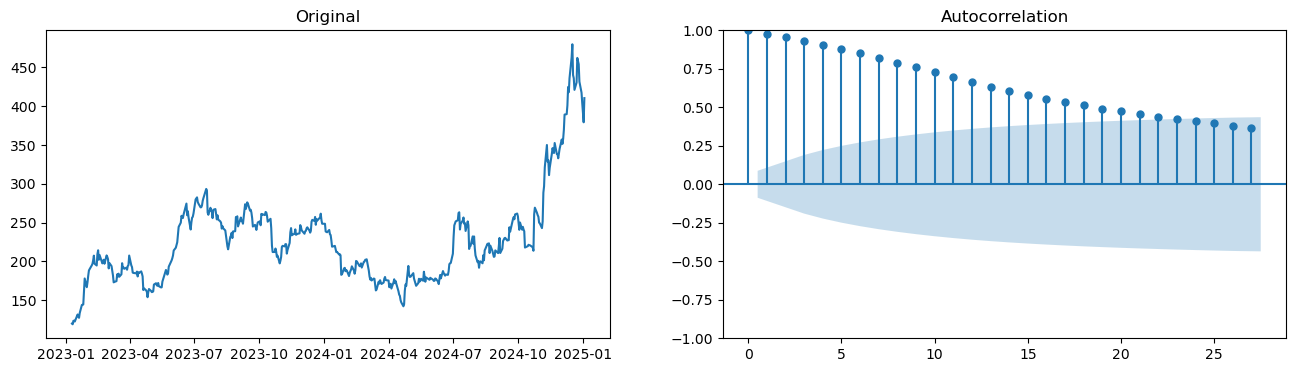

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(prices)
ax1.set_title("Original")
plot_acf(prices, ax=ax2);

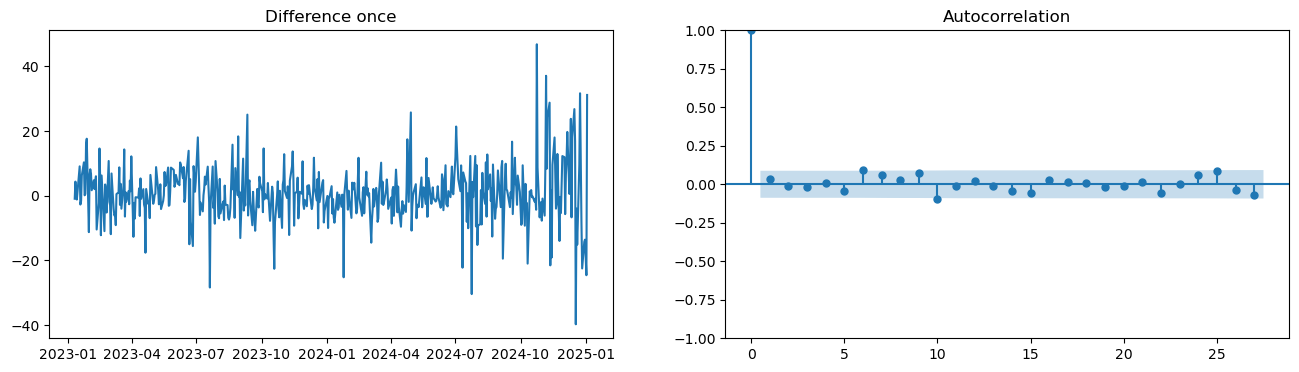

In [11]:
diff = prices.diff().dropna()

fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);

In [12]:
#pmdarima package to get the number of differencing 

from pmdarima.arima.utils import ndiffs
ndiffs(prices, test="adf")

1

# 1 is d order

### p (order of Auto Regressive(AR) term)
- it refers to the number of lags to be used as predictors
- find out the required number of AR terms by inspecting PACF(partial autocorrelation) plot 

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf

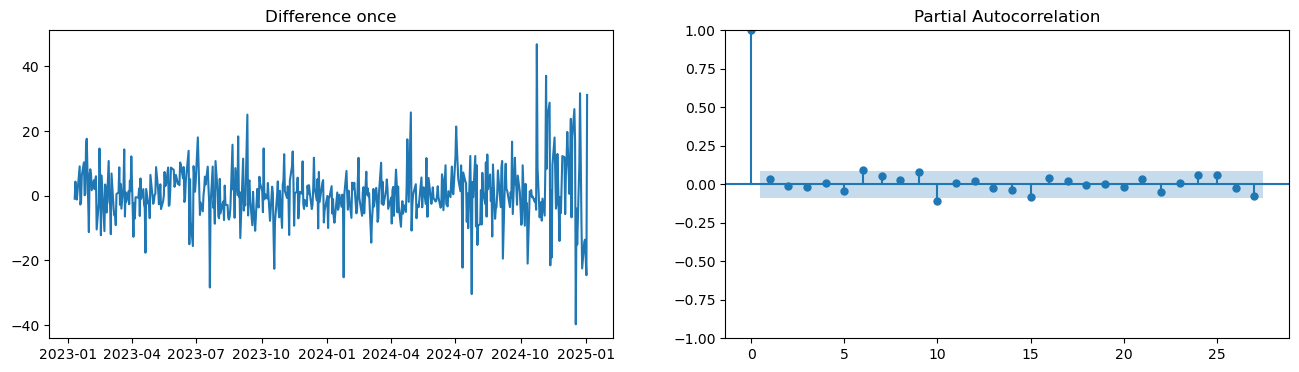

In [14]:
diff = prices.diff().dropna()

fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

We can observe that the PACF lag 10 is significant as it's under the significance line.

# 10 is p order

### q (order of the Moving Average(MA)term)
- it refers to the number of lagged forecast errors that should go into the ARIMA model.
- ACF plot for the number of MA terms

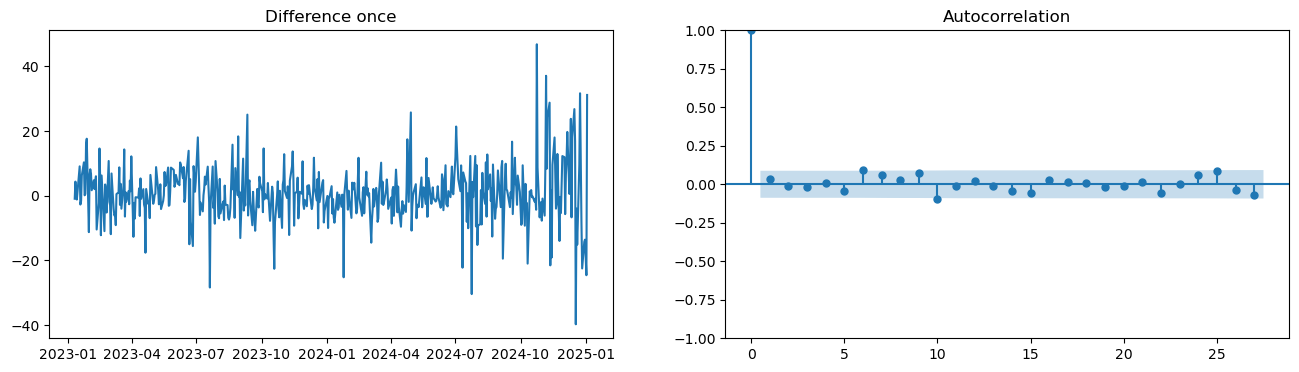

In [15]:
diff = prices.diff().dropna()

fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

# 1 is q order

## Fitting the ARIMA model

In [16]:
#building the model of ARIMA

model = ARIMA(prices, order=(10, 1, 1))
fitted = model.fit() 
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  500
Model:                ARIMA(10, 1, 1)   Log Likelihood               -1784.590
Date:                Mon, 06 Jan 2025   AIC                           3593.180
Time:                        04:32:44   BIC                           3643.731
Sample:                             0   HQIC                          3613.018
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0187      0.343      0.054      0.957      -0.654       0.691
ar.L2         -0.0104      0.036     -0.287      0.774      -0.081       0.060
ar.L3         -0.0195      0.039     -0.505      0.6

(array([0.00037452, 0.00636681, 0.04581604, 0.00848907, 0.00112355,
        0.00012484, 0.        , 0.        , 0.        , 0.00012484]),
 array([-40.43591789, -24.41532643,  -8.39473498,   7.62585647,
         23.64644793,  39.66703938,  55.68763083,  71.70822228,
         87.72881374, 103.74940519, 119.76999664]),
 <BarContainer object of 10 artists>)

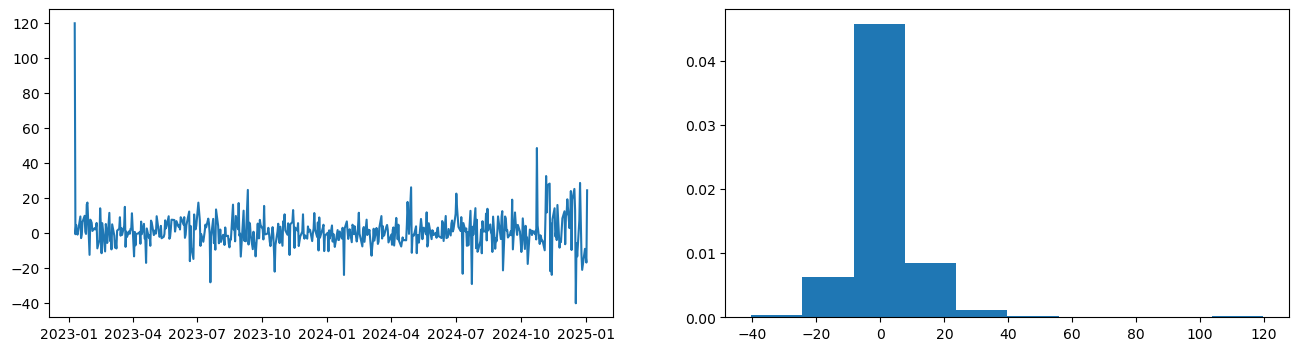

In [17]:
#Plot residual errors
residuals = pd.DataFrame(fitted.resid)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

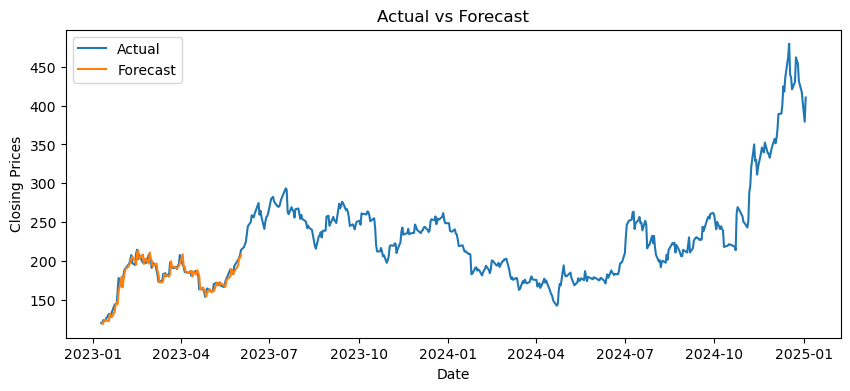

In [18]:
forecast = fitted.get_prediction(start=1, end=100, dynamic=False)
 
#actual vs forecast
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.plot(forecast.predicted_mean)
plt.ylabel("Closing Prices")

plt.xlabel("Date")
plt.title("Actual vs Forecast")
plt.legend(["Actual","Forecast"])



In [ ]:
#prediction the next day price
next_day_price = fitted.forecast(100,alpha=0.05) # next 100days prediction, 95% of confidence level 
print(next_day_price)

500    413.269495
501    414.528498
502    412.732115
503    407.497166
504    400.780537
          ...    
595    406.812533
596    406.812533
597    406.812533
598    406.812533
599    406.812534
Name: predicted_mean, Length: 100, dtype: float64


In [ ]:
predicted_price= next_day_price.values[0]
print(f"The predicted_price for {tomorrow} tomorrow:", predicted_price)

The predicted_price for 2025-01-07 tomorrow: 413.26949470724304


<!-- ### Train test split --> -->

In [ ]:
# n = int(len(prices) * 0.8)
# train = prices[:n]
# test = prices[n:]

# print(len)

In [ ]:
# model = ARIMA(train, order=(10,1,1))
# fitted = model.fit()
# fitted.summary()

In [21]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(16,4))
# plt.plot(train)
# plt.title("Train Data")
# plt.show()


In [22]:
# from pmdarima.arima import auto_arima

# model2= auto_arima(train, seasonal =True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
# fitted2= model2.fit(train)
# print(fitted2.summary())